---
title: Coding & Writing Sample
date: 2025-05-07
authors:
  - name: Shane Grigsby
    affiliations:
      - Cooperative Institute for Research in Environmental Sciences
---

# Context for this coding & writing sample

I presented a version of this notebook on Tuesday, April 29th to [Fernando Perez](https://en.wikipedia.org/wiki/Fernando_P%C3%A9rez_(software_developer))'s research group at UC-Berkely as part of an ongoing biweekly collaboration for cross disciplinary open science. I've modified it slightly to:

  1. Add context that I had previously noted verbally
  2. Reduce the computational complexity of the example so that it can run on a single [binder](https://jupyter.org/binder) instance
  3. Created a [repository](https://github.com/espg/coding-sample) so that software dependencies can be built automatically, and the data is present for the binder instance

This notebook can be run for free from any web browser be clicking the following binder link: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/espg/coding-sample/HEAD?urlpath=%2Fdoc%2Ftree%2FGaussianProcesses.ipynb)

Gaussian Processes (GPs) are a machine learning technique that has wide application-- including [Bayesian estimation of parameter weights](https://en.wikipedia.org/wiki/Neural_network_Gaussian_process) for neural networks. This coding sample provides an introduction to the background and basics around GPs, and unifies some terminology across Data Scientists, Statisticians, and Earth Scientists.

# Gaussian Processes Prediction

Terminology in science is often confusing. For instance, Principle Component Analysis (PCA) and Empirical Orthogonal functions (EOF) are functionally the same numerical method, with EOFs being the preferred term in Atmospheric communities and PCA being the more general term used in broader statistical discussions. Similarly, Gaussian Processes is the general term used in physics and statistical learning for what the geosciences has traditionally termed 'kriging', and which some branches of math refer to as Wiener–Kolmogorov prediction.

Gaussian Processes (GP) are perhaps best thought of as a collection of enhancements to the traditional kriging system. They are functionally equivalent to kriging ([Williams (1998)]( https://doi.org/10.1007/978-94-011-5014-9_23)), and differ only in implantation details and slightly in philosophy. **The GP philosophy treats interpolation as model selection from an infinite number of functions ([Rasmussen & Williams (2005)](https://doi.org/10.7551/mitpress/3206.001.0001))**. 

![gp.png](https://upload.wikimedia.org/wikipedia/commons/7/7f/Gaussian_Process_Regression.png)

*The model of covariance determines which kinds of functions are in the prior. Observations then are used to select functions from the prior which are compatible with those observations. The distribution of those selected functions provide uncertainty estimation*

Although stated somewhat differently, this Bayesian view fits with [Matheron’s](https://doi.org/10.2307/1425829) discussion of random fields, and is a close match to [Journal’s](https://doi.org/10.1007/bf02067214) description of projection into various solution spaces. These 'prior' functions are not required to be linear, as the figure below demonstrates: 

![animation.gif](https://upload.wikimedia.org/wikipedia/commons/d/da/Gaussianprocess.gif)

*As number of predictions 'P' grows to be large above, the mean of all 'P' approaches the best estimate, with the variance of predictions indicating a confidence bound (i.e., the std. dev. of predictions)*

**The primary object of interest in kriging is the variogram**, which is the main method by which practitioners fit a covariance function. **In contrast, the primary object of interest in GPs is the kernel, which is directly equivalent to covariances.** The kernel formulation has significant computational savings, enabling solving of high dimensional kernel functions in low dimensional space via the kernel trick (i.e., computing only the inner products); the kernel formulation also admits easy translation to Fourier based methods when interpolating regular spaces ([Wilson & Adams (2013)](https://doi.org/10.48550/arXiv.1302.4245)). Kernel architecture is flexible, as valid kernels can be added or multiplied to form new synthesis kernels ([Cressie & Huang (1999)](https://doi.org/10.1080/01621459.1999.10473885 )). For instance, non-stationary kernels can be combined with stationary kernels and white noise kernels, such that large spatial trends, local correlation and structure, and intrinsic random noise and error can be modeled and specified as discrete submodules and functions-- [see here for a practical example using Mauna Loa data](https://towardsdatascience.com/gaussian-process-kernels-96bafb4dd63e/) in scikit-learn. Kernels can also be bounded for more efficient computation—for instance, circular and spherical kernels give rise to sparse gram matrices that can be reordered and solved by efficient sparse solvers; the Matérn kernel ([Matérn, 1960]( https://doi.org/10.1007/978-1-4615-7892-5)) can be modified to do the same. Separable non-stationary kernels can be written as a Kronecker tensor product (@genton), and solved in circulant matrixes by efficient Fourier methods ([Wilson & Nickisch (2015)](https://doi.org/10.48550/arXiv.1503.01057)).

Although Gaussian Processes is the more general statistical term for covariance methods of prediction, the practice and term of kriging predates Gaussian Processes. Thus, to explain the history and theory of Gaussian Processes, we'll start with kriging first.

## What is kriging (informally)?

Generally speaking, most people use kriging as an interpolator. Classic interpolators can be split into ‘*estimators*’ and ‘*predictors*’; this distinction (in line with [Cressie, 1990]( https://doi.org/10.1007/bf00889887)) mainly applies to highlight that ‘*estimators*’ provide an estimate of the surface, while ‘*predictors*’ assign a prediction that is accompanied by measures of confidence:

![image.jpg](https://github.com/YuePanEdward/PPE_Kriging/blob/main/figures/result_dense_dataset.jpg?raw=true)

*Estimators including nearest neighbor, bilinear interpolation, and cubic spline (bottom), as compared with kriging predictions using three different kernels (top). The middle row shows the variance of the kriging prediction, which shows how confident we are of the prediction at that location*

Traditional ‘*estimators*’ are of the fairly boring type that most are fairly familiar with— canonical examples are bilinear interpolation, Inverse Distance Weighting (IDW), cubic convolution, etc. Other non-traditional examples of 'estimators' include things like nearest and natural neighbor interpolation, which are appropriate for specific domain cases when you want to preserve original data values. If your **goal** is **just** interpolation **and you have sufficient data**, using an estimator is perfectly fine-- and fast! However, if your data is **sparse**, kriging starts to become more appealing:


![image.jpg](https://github.com/YuePanEdward/PPE_Kriging/blob/main/figures/result_sparse_dataset.jpg?raw=true)

*There is less data, which is more widely spaced, so the uncertainty shown in the middle row has increased*

This sparse estimation capability is why kriging was originally developed. Kriging is named after Danie G. Krige, who's 1951 master's thesis developed and described what we call 'Simple Kriging'. Danie Krige was a prospector looking for gold in South Africa, an application that had sparse input measurements, and expensive sampling. Krige's method was coined 'kriging' by the early 1960's by French mathematician Georges Matheron, who formalized and expanded the method.

Of course, the other case where kriging is appealing is when you need to use the method as a *predictor*.

## Covariance, Gold, and the variogram model

![image.gif](https://vsp.pnnl.gov/help/image/Variogram.gif)

Traditional kriging defines a **model of covariance** by fitting a function to the empirical 'variogram', which plots the variance between observations as a function of distance between those observations. The variogram 'sill' refers to variance between uncorrelated samples, and the 'range' is the lag-distance at which this paired observation decorrelation occurs. The 'nugget' refers to the intrinsic variance (i.e., the observational uncertainty) at distance zero-- that is, the variance of a single point observation with itself. The term 'nugget' is literally referring to 'gold nugget' in the context of prospecting; i.e., finding a 'nugget' of gold which has been displaced from the source gold deposit... just because a 'nugget' is present at a location, does not guarantee that you are coincident with the gold deposit *that generated that observation*; however, the expectation is that the nugget is spatially close to the ore that it came from!

![image.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_gpr_noisy_targets_003.png)

Mathematically, specifying a 'nugget' value (or `alpha` in GP terminology) is effectively adding a constant to the diagonal of the covariance matrix such that each observation has some level of variance with itself. Doing this allows flexibility for the mean of the predictions to *not* intersect all of the observation points-- if covariance is set to unity along the diagonal, then any estimation will be a 'rubber sheeting' that ensures the output mean prediction passes through the original data points. Of course, we can also specify covariance *per observation* rather than as a constant along the diagonal, and selectively *down weight* low confidence observations.

## What I use Gaussian Processes for

My science background is Earth Science, specifically glaciology and hydrology around the polar ice systems. Much of what we know about glacial hydrology is from remote sensing observations, which we use machine learning to process.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from osgeo import osr
import pyproj
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RBF

In [3]:
data = pd.HDFStore("./Z62SU06" + ".h5", 'r') # ICESat data

The filename `Z62SU06` refers to **Z**wally drainage basin **6.2** from **Su**mmer of 20**06**, and the observations are from the first space based laser altimeter, the [NASA ICESat mission](https://icesat.gsfc.nasa.gov/icesat/). Here's where basin 6.2 is in Greenland:

![greenland.png](https://earth.gsfc.nasa.gov/sites/default/files/lab_cryo/data/polar_ice_altimetry/antarctic_and_greenland_drainage_systems/grn_drainage_systems.png)


In [4]:
coordlist = data['coords'] # Needed for distance calculations / plotting
df_indices = data['indices'] # UUID to link to observations to slope retrievals
df_corr = data['corr'] # Filter and weight data

gslope = np.load('./General_slopes.npy') # Sub ICESat footprint slope retrievals
mean_slope = np.zeros(len(coordlist))
std_slope = np.zeros(len(coordlist))

# Merge and aggregate slope
for i in tqdm(range(len(coordlist))):
    sweights = np.array(df_corr.iloc[i].values)
    weightidx = np.isfinite(sweights)
    sweights = np.abs(sweights[weightidx])
    sidx = df_indices.iloc[i].values[weightidx]
    sidx = np.array(sidx, dtype=int)
    mean_slope[i] = np.average(gslope[sidx], weights=sweights)
    std_slope[i] = np.std(gslope[sidx])

  0%|          | 0/23359 [00:00<?, ?it/s]

This example is meant to be larger than a 'toy' dataset, but still small enough to interact with and demonstrate. Our input data consist of 23,359 observations which are within footprint slope retrievals from the first ICESat mission (which flew from 2003 to 2009, although laser power was strongest in the first three years).

Here's what the data looks like:

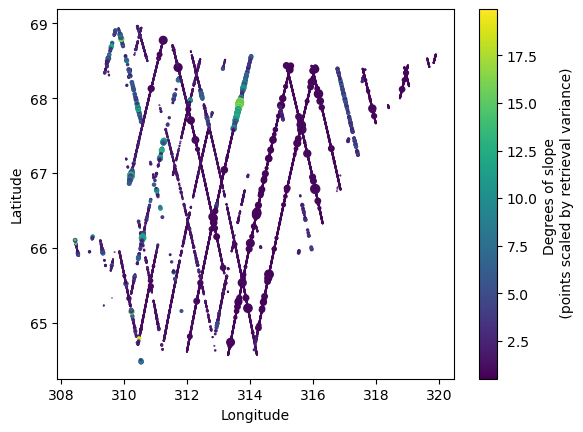

In [5]:
fig, ax = plt.subplots()
im = ax.scatter(coordlist.lon, coordlist.lat, c=mean_slope, s=std_slope**2)
im.set_clim(min(mean_slope), max(mean_slope))
plt.xlabel("Longitude"), plt.ylabel("Latitude")
fig.colorbar(im, ax=ax, label="Degrees of slope \n (points scaled by retrieval variance)")
plt.show()

Each 'line' above is an orbital pass, also called a 'track'. This is an interesting case of geostatistics because the sampling is quite odd-- the along track resolution is dense, but the across track resolution is sparse. Most of the code is actually setting up the **source** and **target** coordinate systems for the model. The input observational data is irregularly spaced and in lat/lon coordinates (one degree of Latitude is 110km), but we want our distance measurements to be in Euclidean space and output to a grid.

In [6]:
# Projection object
ds = osr.SpatialReference()
ds.ImportFromEPSG(3411) # polar projection
ds.ExportToProj4()
p2 = pyproj.Proj(ds.ExportToProj4())

# Observations to meters from lat / lon
X, Y = p2(np.array(coordlist.lon),
          np.array(coordlist.lat))
# To vector form sklearn
coords_m = np.ones((len(coordlist),2))
coords_m[:,0] = X
coords_m[:,1] = Y

Our input (source) data was already filtered to drainage basin 6.2, but we also want to 'clip' the (target) results to a drainage basin. This is for two reasons-- first, the drainage basin boundaries are at zero surface slope and provide a physically meaningful way to bound, divide, and tile the analysis. And second, covariance functions are expensive, so clipping and masking the edges of our area of interest helps things run faster... it also makes the output look good!

In [7]:
# Drainage basin boundries
zwally = pd.read_csv('./GrnDrainageSystems_Ekholm.txt',
                     sep=r"\s+", names=['basin', 'lat','long'])
basin = '6.2'
LL = zip(zwally[zwally.basin == float(basin)].long,
         zwally[zwally.basin == float(basin)].lat)
LL = list(LL)
# Convert basin boundries to meters from lat / lon
pX, pY = p2(np.array(LL)[:,0],
            np.array(LL)[:,1])
# Polygon object for masking
Z = mpl.path.Path(list(zip(pX, pY)))

# Setting up kriging grid
x1, y1 = np.meshgrid(np.r_[round(min(pX), -2) - 2500:round(max(pX), -2) + 2500:5000],
                     np.r_[round(min(pY), -2) - 2500:round(max(pY), -2) + 2500:5000])
kcoords = np.vstack([x1.ravel(),y1.ravel()]).T

# Masking kriging grid
Zidx = Z.contains_points(kcoords[:])
target_c = kcoords[Zidx] # Target coordinates
x1.shape, len(target_c)

((108, 110), 5600)

At this point, we've setup a 5-km grid to predict on that's 108 by 110 (a little over 500km per side), which after masking has 5,600 target coordinate locations to predict at. 

Our source observations are too large for a binder instance to use for the GP model, which is n-squared in memory complexity with number of observations. We subsample by randomly selecting 4,000 observations to fit our model to:

In [8]:
rng = np.random.default_rng() # numpy sampling API
np.random.seed(12)
ind = np.array(range(0,len(coordlist)), dtype=int) # index values to map to observations
idxs = np.random.choice(ind, size=4000) # randomly pick 4,000 indices

The actual Gaussian Process model specification is fairly short:

In [9]:
%%time
noise = WhiteKernel(noise_level=.5)
rbf = 3 * RBF(length_scale=[80000,80000])
kern = 2.0 * Matern(length_scale=[80000,80000], length_scale_bounds=(1e3, 1e6),
                        nu=0.5)
gp1 = GaussianProcessRegressor(kernel=rbf+kern+noise, alpha=std_slope[idxs]**2, optimizer=None).fit(coords_m[idxs], mean_slope[idxs])

CPU times: user 4.66 s, sys: 2.2 s, total: 6.86 s
Wall time: 1.03 s


We are specifying a `Matern` kernel to calculate and estimate our local covariance structure, which is defined by the single parameter `nu`; this parameter controls how smooth the functions are within our prior distribution of possible surface functions. It is set at 0.5 (i.e., '1 / 2', equivalent the absolute exponential kernel) to allow rough, non-differentiable candidate functions; a `nu=1.5` (3 / 2) will select from functions that are once differentiable, `nu=2.5` (5 / 2) will select from functions that are twice differentiable, and `nu=inf` will converge to the infinitely differentiable `RBF` kernel. In addition to the `Matern` kernel, I've also added an `RBF` kernel to model the large scale gradient of slope as it decreases moving inland, and a `WhiteKernel` to reflect that we expect some noise in the input data.

The `length_scale` parameter would typically be optimized during model fit based on the spatial structure of the data... however, because our input data is heavily unbalanced (i.e., dense in the along track direction, sparse in the across track), hyper-parameter optimization sets a length scale that is too short, so it is fixed at 80km, with similar settings applied for the `length_scale_bounds`.

After model specification, at `fit` time we provide the coordinates, and slope values, along with an `alpha` that is set to variance of slope retrieval (i.e., estimates of variance per observation).

We can get the mean surface estimate and target-to-target covariances with the following:

In [10]:
%%time
y_mean, y_cov = gp1.predict(target_c, return_cov=True)

CPU times: user 11.5 s, sys: 2.03 s, total: 13.5 s
Wall time: 2.05 s


We'll return to plot the results after discussing what is actually happening in the cell above.

## What is kriging (formally)?

Mathematically, kriging is the Best Unbiased Linear **Predictor** ([(Journel (1977)](https://doi.org/10.1007/bf02067214) ; [Cressie (1990)](https://doi.org/10.1007/bf00889887) ; [Handcock & Stein (1993)](https://doi.org/10.1080/00401706.1993.10485354)), and provides the Best Linear Unbiased Prediction, or BLUP; this means that kriging prediction is a linear combination of weighted observations at point p that minimizes prediction variance. Note that this is different (but related) to the Best Linear Unbiased **Estimation**, or BLUE... although when using kriging to *estimate* a quantity, the results will be equivalent to the BLUE, which is why kriging is often conceptually understood as equivalent to spatially weighted least squares regression. Below is mathematical formulation for simple kriging, which assumes we are modeling a stationary (i.e., zero mean) process. 

We adopt the standard convention of using $s_i$ for *source* observations (known), and $t_i$ for *target* predictions (predicted). Given $N$ observations $(s_1…s_n)$, and a covariance function $f_{cov}()$, we calculate distances $D$ of $N$ *source* observations, and use either a function or kernel for source covariances $C_{obs}$:

$$D(s_1 ... s_n, s_1 ... s_n) = D_{obs}$$
$$C_{obs} = f_{cov}(D_{obs}) \quad \textrm{or} \quad C(\mathbf{x}_n, \mathbf{x}_m) = k(\mathbf{x}_n, \mathbf{x}_m)$$

This is what is happening here:

```python
kern = 1.0 * Matern(length_scale=[80000,80000], length_scale_bounds=(1e3, 1e6),
                        nu=0.5)
gp1 = GaussianProcessRegressor(kernel=kern, alpha=std_slope**2, optimizer=None).fit(coords_m, mean_slope)
```

We are selecting a covariance function (i.e., the Matern kernel), and then **fitting** that function to our observations on the basis of distance in order to estimate source-to-source covariance, $C_{obs}$.

Using the assumption that covariance can now be specified as a function of distance, we can model the covariance between our observations and prediction locations, that is the covariance between the source and target locations $C_{obs\_pred}$:

$$D(s_1 ... s_n, t_1 ... t_n) = D_{obs\_pred}$$
$$C_{obs\_pred} = f_{cov}(D_{obs\_pred})$$

While we don’t actually know the target prediction values of $t_1…t_n$ above, *we do know the locations* of $t_1…t_n$, and hence we can calculate their distances from our source $s_1 ... s_n$ locations. This also means we can model the covariance of the predictions $t_1…t_n$ as a function of distance, under the assumption that $C_{pred}$ has the same spatial structure as $C_{obs}$:

$$D(t_1 ... t_n, t_1 ... t_n) = D_{pred}$$
$$C_{pred} = f_{cov}(D_{pred})$$

We obtain the kriging weights $W$ by linear regression of the source-to-source covariances onto the source-to-target target covariances:

$$W = C_{obs}^{-1} \cdot C_{obs\_pred}$$

Above we see the key computational constraint for kriging; we need to be able to invert an N by N observation covariance matrix. Kriging is considered spatially weighted least squares because the covariances are calculated as a function of distance, and $C_{obs}^{-1} \cdot C_{obs\_pred}$ is Ordinary Least Squares fitting-- which is equivalent to maximum likelihood estimation. The regression/kriging weights are identical for both the observations and their covariances, and we now have enough information to make a kriging/Lstsq’s prediction at the $t_1…t_n$ target locations:

$$[t_1…t_n] =  W^T \cdot [s_1…s_n]$$

The kriging weights are used to produce a prediction at each target location that is a weighted linear combination of our source observation data, which is why the technique is the "Best Linear Unbiased Prediction"-- it is a prediction from a linear combination of observations, with the combination weighting determined by maximum likelihood estimation. 

Our 'mean' prediction (and the steps above to retrieve them), happens at this call, which also returns the $C_{pred}$:

```python
y_mean, y_cov = gp1.predict(target_c, return_cov=True)
```

This gives us the mean of all possible predictions, i.e., `y_mean` above. If we want to get **a prediction** instead of the *mean of predictions*, we use the $C_{pred}$ to draw spatially correlated simulations, which are added to that mean. Specifically, we can preform simulation via Cholesky decomposition\* using the derived mean target predictions, and the target-to-target covariance:

(from [sklearn gaussian process module](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/gaussian_process/_gpr.py)):
```python
    def sample_y(self, X, n_samples=1, random_state=0):
        """Draw samples from Gaussian process and evaluate at X.

        Parameters
        ----------
        X : array-like of shape (n_samples_X, n_features) or list of object
            Query points where the GP is evaluated.

        n_samples : int, default=1
            Number of samples drawn from the Gaussian process per query point.

        random_state : int, RandomState instance or None, default=0
            Determines random number generation to randomly draw samples.
            Pass an int for reproducible results across multiple function
            calls.
            See :term:`Glossary <random_state>`.

        Returns
        -------
        y_samples : ndarray of shape (n_samples_X, n_samples), or \
            (n_samples_X, n_targets, n_samples)
            Values of n_samples samples drawn from Gaussian process and
            evaluated at query points.
        """
        rng = check_random_state(random_state)

        y_mean, y_cov = self.predict(X, return_cov=True)
        if y_mean.ndim == 1:
            y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T
        else:
            y_samples = [
                rng.multivariate_normal(
                    y_mean[:, target], y_cov[..., target], n_samples
                ).T[:, np.newaxis]
                for target in range(y_mean.shape[1])
            ]
            y_samples = np.hstack(y_samples)
        return y_samples
```

\*Since we know that our covariance function produces a positive definite gram matrix of covariances, we use cholesky because [it is faster than SVD or eigen decomposition](https://numpy.org/doc/2.2/reference/random/generated/numpy.random.Generator.multivariate_normal.html#numpy.random.Generator.multivariate_normal). (The cholesky, SVD, or eigen decomposition is what is called behind the scene for the `rng.multivariate_normal` function above.)

## Why do we care about 'Prediction' of slope for glaciology?

Slope is an important variable for glaciologists, but it also doesn't vary much on the icesheet-- it goes from about 2 degrees at the edge where it's 'steep', before gradually dropping down to 1 in the interior and eventually 0 at the drainage boundary. However, things change when the surface is crevassed; cracks present a range of surface heights and angles, and generally those retrievals are **not** flat:

![crevs.jpg](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Parque_estatal_Chugach%2C_Alaska%2C_Estados_Unidos%2C_2017-08-22%2C_DD_94.jpg/1280px-Parque_estatal_Chugach%2C_Alaska%2C_Estados_Unidos%2C_2017-08-22%2C_DD_94.jpg)

Crevasses on the Greenland icesheet aren't static features, they are linked to hydrologic system, occur seasonally, and can open (or close) on the time scale of hours:

![image.png](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-018-03420-8/MediaObjects/41467_2018_3420_Fig5_HTML.jpg?as=webp)

*Figure from our [2018 Nature Communications Paper](https://www.nature.com/articles/s41467-018-03420-8)*

Although we've had satellites for Earth Science since the 1970's starting with the Landsat missions, the record in the arctic is **much** shorter. The Landsat satellites acquired more data than they had capacity to download, and prioritized downloading data over the United States-- areas over the polar ice sheets and the oceans **were deleted** until the last decade. We've only had consistent remote sensing coverage of the polar icesheets for about a decade, which makes it possible to infer how things are now, but hard to infer trends in how things are changing. Our current [best observational model of Greenland is Bedmap](https://sites.ps.uci.edu/morlighem/dataproducts/bedmachine-greenland/), which a snapshot from 2010 airborne flights modeled over a 150-meter spaced grid. The ICESat mission launched in 2003, has our earliest measurements of elevation and slope across the entire icesheet.

If we are looking for crevasses, which are often transitory, we can try and infer them from slope 'anomalies' that we see in the ICESat data record. We know that the 'background' slope of the ice sheet is 3 degrees of slope or lower, and it would be nice to know when and in what areas that slope is exceeded. With simulations of possible slope surfaces, we can count how often 3 degrees of slope is exceeded for a given location:

In [11]:
%%time
realizations = rng.multivariate_normal(y_mean, y_cov, size=100, method='cholesky')

CPU times: user 6.28 s, sys: 1.39 s, total: 7.67 s
Wall time: 856 ms


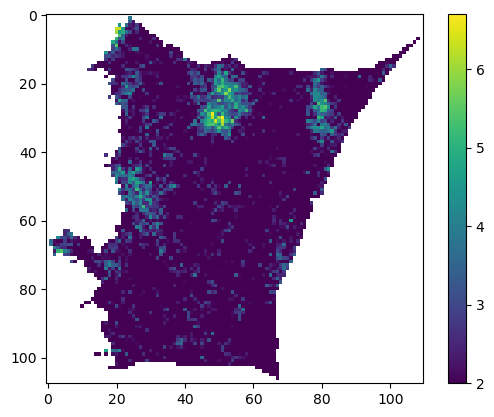

In [12]:
results1 = np.ones(len(kcoords)) *np.nan
results1[Zidx] =  realizations[5]
show_res1 = results1.reshape((x1.shape))
plt.imshow(np.flipud(show_res1), vmin=2)
plt.colorbar()
plt.show()

This is one possible 'realization' of areas that likely have slopes above 2 degrees, and be crevassed; we can easily look at another:

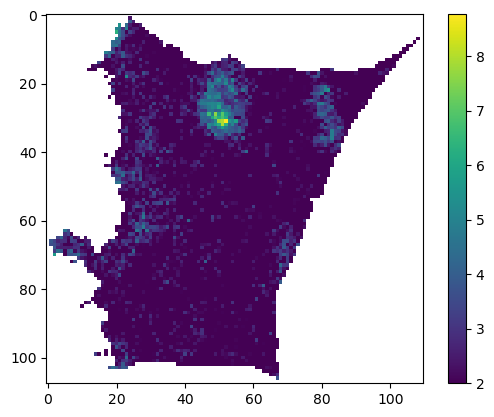

In [13]:
results1 = np.ones(len(kcoords)) *np.nan
results1[Zidx] =  realizations[9]
show_res1 = results1.reshape((x1.shape))
plt.imshow(np.flipud(show_res1), vmin=2)
plt.colorbar()
plt.show()

Ultimately, we take all 100 of our simulations, and count when we exceed our slope threshold to get an envelope estimate of where (in the summer of 2006) it was observationally probable to have crevassing:

In [14]:
occurance = np.zeros(5600, dtype=np.int64)
for i in realizations:
    occurance += i > 3

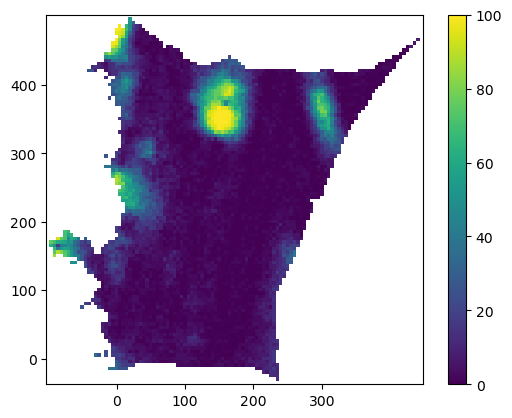

In [15]:
results1 = np.ones(len(kcoords)) *np.nan
results1[Zidx] =  occurance
show_res1 = results1.reshape((x1.shape))
plt.imshow(np.flipud(show_res1)) #, norm=mpl.colors.LogNorm())
ticks = np.array([0,20,40,60,80])
yticks = np.array([100,80,60,40,20])
plt.xticks(ticks[1:],(ticks[0:-1]*5))
plt.yticks(yticks,(ticks*5))
plt.colorbar()
plt.show()

There appears to be a crevasse field that's opened around 150 kilometers inland (around 400 km north of the bottom edge of the drainage basin). This is what the area looked like in early June of 2010 at 300 km north of the basin boundary (red lines denote stress/strain that is high enough for 10 meter deep crevasses to form):

![image.png](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-018-03420-8/MediaObjects/41467_2018_3420_Fig3_HTML.jpg?as=webp)

So stochastic simulations from Gaussian Process modeling suggests crevassing at or above 100 km inland has also happened seasonally in the past north of where we observe it in 2010, with much weaker signal for possible slope anomalies beyond 200 km inland.

## Notes on Covariance and Kernels

Several things are apparent for the kriging description above, that highlight both the strengths and weakness of the approach. First and foremost, *the approach is dependent on specification of a proper covariance function, or combination of kernels*.
 
Observe the following GP kernels (i.e., covariance models), fitted to the same data; note that every model consistently *predicts* an additional drop *beyond the observations* between x=4 and x=5; this is a strength of GPs, since interpolation using most other estimators cannot exceed the min/max of the observation space, even if the data is indicative of a trend! 

![gp1.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_gpr_prior_posterior_001.png)
![gp1.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_gpr_prior_posterior_002.png)

*Note that the next kernel is modeling period functions (applicable to basin and range features)*

![gp1.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_gpr_prior_posterior_003.png)
![gp1.png](https://scikit-learn.org/stable/_images/sphx_glr_plot_gpr_prior_posterior_005.png)

 **The covariance function must be invertible; that is it must be positive definite (Genton, 2002)**, and the machine that runs the computation must be capable of inverting a N by N matrix. In practice, the N by N inversion can be relaxed if only the ‘best’ prediction is desired (since it can be derived via lstsq calculation); *however, simulation and error estimation requires inversion of an N by N matrix.* **In practice, empirical covariance almost always provides a non-invertible (not positive definite) gram matrix (@10.1080/00401706.1993.10485354); further, a model of covariance is needed to estimate source to target and target to target covariance—so estimation of a covariance function, either via a variogram or by other methods, is always required for geostatistical interpolation and simulation.** The error estimation that kriging gives per prediction is error estimation on the assumption that modeled covariance structure is true! Kriging has been characterized as the Best Unbiased Linear Predictor (BULP)… which it is, for a given covariance function. Swapping covariance functions gives different and competing BLUPs, which then need to be evaluated via inter-model comparison ([]( https://doi.org/10.1162/neco.1992.4.3.415)). In short, the kriging error and uncertainty estimation is not the absolute error estimate for the surface, and probability estimation of a prediction must be obtained with other models to give realistic confidence bounds. There are also various flavors of kriging (ordinary, universal, block, etc.) (see [Journel](10.1007/bf02067214)), which are similar to above, and account for non-stationarity.